# Fine-Tuning BERT for Sentiment Analysis in vanilla PyTorch

## Installations

In [ ]:
!pip install --quiet transformers[torch]
!pip install --quiet datasets

     |████████████████████████████████| 2.3MB 4.4MB/s 
     |████████████████████████████████| 3.3MB 20.3MB/s 
     |████████████████████████████████| 901kB 36.5MB/s 
     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 245kB 27.5MB/s 
     |████████████████████████████████| 122kB 24.9MB/s 


## Imports

In [ ]:
import torch # pytorch
import transformers # from huggingface
from datasets import load_dataset # function to load a dataset that is pre loaded
import pandas as pd # used for data analysis and manipulating data
torch.cuda.empty_cache()

## Load Dataset

In [ ]:
raw_datasets = load_dataset("imdb") # load the IMDB dataset

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a. Subsequent calls will reuse this data.


In [ ]:
df_train = pd.DataFrame() # store data
df_test = pd.DataFrame()
df_val = pd.DataFrame()

In [ ]:
# take the (text, label) pairs and put them into dataframe
df_train['text'], df_train['labels'] = raw_datasets['train']['text'], raw_datasets['train']['label']
df_test['text'], df_test['labels'] = raw_datasets['test']['text'], raw_datasets['test']['label']

In [ ]:
df_train = df_train.sample(1000) # samples 1000 random samples for our training dataset

In [ ]:
df_test_sample = df_test.sample(1000) # samples 1000 random samples for our test dataset

In [ ]:
df_test = df_test_sample[:500] # Assign first 500 of test samples as test

In [ ]:
df_test.shape

(500, 2)

In [ ]:
df_val = df_test_sample[500:] # assign last 500 of test samples as validation samples

In [ ]:
df_val.shape

(500, 2)

In [ ]:
# The whole dataset of 2000 samples
data = df_train.append(df_test)
data = data.append(df_val)

In [ ]:
data.shape

(2000, 2)

In [ ]:
from sklearn.model_selection import train_test_split # This function automatically splits our dataset


X = data.text.values # All our text samples
y = data.labels.values # All our labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Assign 30% to test and 70% of data to train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5) # Out of the training samples, assign half as validation

In [ ]:
X_val.shape[0] + X_test.shape[0] + X_train.shape[0]

2000

## Set up GPU on PyTorch

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda") # this is the device our model will use for computing
  print(f'There are {torch.cuda.device_count()} GPUs available')
  print(f'Device name:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using CPU instead')
  device = torch.device('cpu')

There are 1 GPUs available
Device name: Tesla K80


## Text Preprocessing

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

### BERT Tokenizer
In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we have to also add special tokens (`CLS` and `SEP`) to the start and end of each sentence, pad and truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask

In [ ]:
from transformers import BertTokenizer # Importing the tokenizer used for BERT

# Defined Tokenizer for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
import re
# Define function to tokenize a set of text (all this is doing is applying our tokenizer defined above to our data)
def bert_preprocess(data):
  # empty lists to store outputs
  input_ids = [] # These are the numbers we get for each token once we tokenize
  attention_masks = [] # These are what we want to pay attention to when going through the self-attention layer in BERT

  # For every sentence/sample in our data, we run it through the BERT tokenizer
  for text in data:
    tokenized_text = tokenizer.encode_plus(
        text=text_preprocessing(text), # feed in preprocessed text for each sample
        add_special_tokens=True,      # include [CLS] and [SEP]
        max_length=512,               # for truncation/padding (how many tokens can it tokenize)
        pad_to_max_length=True,       # Pad text to max length,
        truncation=True,              # truncate down to 512 numbers
        return_attention_mask=True    # return attention mask
    )

    # add each output to the lists
    input_ids.append(tokenized_text.get('input_ids'))
    attention_masks.append(tokenized_text.get('attention_mask'))
  
  # List to PyTorch tensors to get ready to use for computation
  input_ids = torch.Tensor(input_ids)
  attention_masks = torch.Tensor(attention_masks)

  return input_ids, attention_masks

In [ ]:
import numpy as np
# Concatenate train and test data
all_data = np.concatenate([df_train.text.values, df_test.text.values])

# Encodes all our concatenated data
encoded_data = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]

# Find max length of text
max_length = max([len(text) for text in encoded_data])
print('Max Length: ', max_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (948 > 512). Running this sequence through the model will result in indexing errors


Max Length:  2132


In [ ]:
MAX_LEN = 1450

token_ids = list(bert_preprocess([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

train_inputs, train_masks = bert_preprocess(X_train)
val_inputs, val_masks = bert_preprocess(X_val)

Original:  I enjoyed this movie so much that I watched it twice and that is something to say about a documentary. The musical score, cinematography and sound are absolutely stunning as you might expect from an Imax production. Even though it is shot for those huge Imax theaters, it looks and sounds wonderful on my home system. In fact this would make a perfect DVD to demo your system.<br /><br />The subject is also so fascinating. It is about Mario Andretti and his son Michael. I was already a fan of Mario because he is the best racecar drive in history since he is the only person to win the CART Championship, F1 Championship, The Daytona 500 and the Indianapolis 500. The script follows the path of two cars very important to the father and son. The first car is found in a chicken coop and turns out to be the first roadster that Mario ever drove and we follow restoration to gleaming perfection. The other car is Michael's new racecar and we follow it from cutting the mold through the rac

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Instantiate PyTorch DataLoader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Create iterator for our dataset

# Convert data to tensors
train_labels = torch.Tensor(y_train) # These are just list of 0 and 1 from our training set
val_labels = torch.Tensor(y_val) # These are just list of 0 and 1 from our validation set

# Batch size (how many samples will we feed in to optimizer at once)
batch_size = 8

# Create training DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
# I know that I need to feed in 8 samples at a time to the model!!! ~ train_dataloader
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # IMPORTANT!!!

# Create validation DataLoader
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Training the Model

### BERT Classifier

In [ ]:
import torch.nn as nn # allows us to define class as neural network module
from transformers import BertModel # We got the BERT pre-trained model!

# Create the BertClassifier class
class BertClassifier(nn.Module):
  def __init__(self, freeze_bert=False):
    super(BertClassifier, self).__init__()

    # hidden size of BERT, hidden size of classifier and num labels
    d_in = 768 # This is the hidden layer size in BERT
    hidden_dim = 50 # This is the dimension of hidden layer for our neural network classifier!
    d_out = 2 # Why is this 2? (Binary Sentiment Classification - 0: negative and 1: positive)

    # LEGO Pieces in action!!!
    # Instantiate BERT
    self.bert = BertModel.from_pretrained('bert-base-uncased') # Our pretrained BERT model from transformers library

    # Let's create a one-layer output layer as our LEGO block classifier
    self.classifier = nn.Sequential(
        nn.Linear(d_in, hidden_dim), # it will take as input a vector that is 768 in dimension and output dimension 50
        nn.ReLU(), # activation function that bounds our outputs to between 0 and 1 so that our gradients don't get too large
        nn.Linear(hidden_dim, d_out) # it will take as input a vector that is 50 in dimension and output dimension 2 
    ) # This is what we will tag onto BERT for sentiment classification

    # Freeze BERT weights
    if freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False
    
  # Forwardpass: propagate data through our network defined above
  def forward(self, input_ids, attention_mask):
    ''' Parameters:
    input_ids = what does our text look like in numeric form (tokenized)
    attention_mask = how much does each word 'pay attention' to the other for its encoding
    '''

    # Feed input to BERT
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the hidden state of the [CLS] token for classification
    hidden_state_CLS = outputs[0][:, 0, :] # Tells our model that we want to do classification!!!

    # Feed in BERT output into the LEGO block neural network we defined above
    logits = self.classifier(hidden_state_CLS) # This outputs two probabilities

    return logits


### Optimizer and Learning Rate

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4): # epoch = iteration
  # Instantiate BERT Classifier
  bert_classifier = BertClassifier(freeze_bert=False)

  # Attach model to GPU
  # bert_classifier.to(device)

  # Instantiate Adam Optimizer for Gradient Descent (How are we going to do gradient descent?)
  optimizer = AdamW(bert_classifier.parameters(), lr=5e-5, eps=1e-8)

  # Total number of training iterations
  total_steps = len(train_dataloader) * epochs

  # Set up the scheduler for the learning rate optimization (super nice bc it updates learning rate according to how the model is performing)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  return bert_classifier, optimizer, scheduler # we return our model and how we are gonna do gradient descent

### Training Loop

In [ ]:
import random
import time

# We will use Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss() # this tells model how bad it did

def set_seed(seed_value=42):
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

In [ ]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
  # We want to run our training data through our model
  print('Start Training.......')
  for epoch in range(epochs):
    print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Train Acc':^12} ")
    print("-"*70)

    # Measure the elapsed time of each epoch
    t0_epoch, t0_batch = time.time(), time.time()

    # Reset tracking variables at the beginning of each epoch
    total_loss, batch_loss, batch_counts = 0, 0, 0

    # Put the model into the training mode
    model.train()

    train_accuracy = [] # keep track of accuracies at each iteration

    # Main loop
    for step, batch in enumerate(train_dataloader):
      batch_counts += 1

      # Have to load the current batch (size = 8) to the GPU
      # For each of the 8 examples in our batch, get the input_ids, attention_mask, and ground-truth labels
      batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device).long() for t in batch)

      # Zero out any gradients from previous runs
      model.zero_grad()

      # Forwardpass here we come!
      logits = model(batch_input_ids, batch_attention_mask)

      # Let's now compute the error of the model (Cross Entropy Loss)
      loss = loss_fn(logits, batch_labels) # How does the prediction compare to what the actual label was
      batch_loss += loss.item()
      total_loss += loss.item()

      # Prediction
      predictions = torch.argmax(logits, dim=1).flatten() # This is our predicted label

      # Compute accuracy
      train_acc = (predictions == batch_labels).cpu().numpy().mean() * 100 # grading the model! How many did we get correct?
      train_accuracy.append(train_acc) # keep track of accuracy

      # Time to tell our model what it did wrong! (backpropagation)
      loss.backward()

      # Gradient Clipping: We often do this so our gradients don't get too big and cause our model to run forever
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Tell parameters how to change for next run
      optimizer.step()
      scheduler.step()

      # Print the loss values and time elapsed for every 20 batches
      if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
          # Calculate time elapsed for 20 batches
          time_elapsed = time.time() - t0_batch

          # Print training results
          print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

          # Reset batch tracking variables
          batch_loss, batch_counts = 0, 0
          t0_batch = time.time()

    # Calculate the average loss over the entire training data
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = np.mean(train_accuracy)

    print("-"*70)
    # =======================================


    if evaluation == True:
      # After the completion of each training epoch, measure the model's performance
      # on our validation set.
      val_loss, val_accuracy = evaluate(model, val_dataloader)

      # Print performance over the entire training data
      time_elapsed = time.time() - t0_epoch
      
      print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {train_accuracy:^9.2f}")
      print("-"*70)
    print("\n")

    print("Training complete!")


def evaluate(model, val_dataloader):
  # evaluate our model
  model.eval()

  # List for losses and accuracies
  val_losses = []
  val_accuracies = []

  # For each batch in the val_dataloader
  for batch in val_dataloader:
    # Let's again load our batch to the GPU
    batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device).long() for t in batch)

    # Softmax
    with torch.no_grad():
      logits = model(batch_input_ids, batch_attention_mask)
    
    # COmpute loss
    loss = loss_fn(logits, batch_labels)
    val_losses.append(loss.item())

    # Prediction
    predictions = torch.argmax(logits, dim=1).flatten()

    # Compute accuracy
    acc = (predictions == batch_labels).cpu().numpy().mean() * 100
    val_accuracies.append(acc)

  # Average loss and accuracy
  val_loss = np.mean(val_losses)
  val_accuracy = np.mean(val_accuracies)

  return val_loss, val_accuracy

In [ ]:
# Training time!
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier.to(device), train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start Training.......
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Train Acc   
----------------------------------------------------------------------
   1    |   20    |   0.684713   |     -      |     -     |   29.87  
   1    |   40    |   0.484920   |     -      |     -     |   28.53  
   1    |   60    |   0.435473   |     -      |     -     |   28.95  
   1    |   80    |   0.588908   |     -      |     -     |   29.23  
   1    |   87    |   0.428778   |     -      |     -     |   9.58   
----------------------------------------------------------------------
   1    |    -    |   0.540528   |  0.516980  |   77.84   |   74.29  
----------------------------------------------------------------------


Training complete!
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Train Acc   
----------------------------------------------------------------------
   2    |   20    |   0.233040   |     -      |     -     |   30.74  
   2    |   40    |   0.241897   | 

## Evaluating the Model

In [ ]:
import torch.nn.functional as F

# How does our model perform on data it hasn't trained on/seen before?
def bert_predict(model, test_dataloader):

  # Evaluate
  model.eval()

  all_softmax_results = []

  for batch in test_dataloader:
    # Predict on the first 3 batches
    batch_input_ids, batch_attention_mask = tuple(t.to(device).long() for t in batch)[:2]

    # Compute softmax
    with torch.no_grad():
      logits = model(batch_input_ids, batch_attention_mask)
    all_softmax_results.append(logits)

    # Concatenate all softmax from each batch
    all_logits = torch.cat(all_softmax_results, dim=0)

    # Apply softmax
    preds = F.softmax(all_logits, dim=1).cpu().numpy()

    return preds

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc(probs, y_true):
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Predictions on Test Set

In [ ]:
df_test.shape

(500, 2)

In [ ]:
test_inputs, test_masks = bert_preprocess(X_test)
test_labels = torch.Tensor(y_test)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Create testing DataLoader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
test_labels[:8]

tensor([1., 0., 0., 0., 1., 1., 1., 0.])

AUC: 1.0000
Accuracy: 100.00%


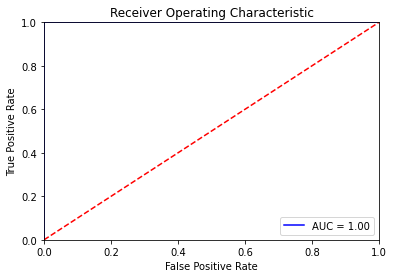

In [ ]:
preds = bert_predict(bert_classifier.to(device), test_dataloader) # RUN test data through our model to see how it does

evaluate_roc(preds, test_labels[:8]) 

In [ ]:
preds.shape

(8, 2)

In [ ]:
preds = np.where(preds[:, 1] > 0.9, 1, 0)

In [ ]:
print(f'Predicted values: {preds}')
print(f'Actual values: {y_test[:8]}')

Predicted values: [1 0 0 0 1 1 1 0]
Actual values: [1 0 0 0 1 1 1 0]


In [ ]:
X_test[:8]

array(['Every one should see this movie because each one of us is broken in some way and it may help us realize 1) My life isn\'t as bad as I thought it was and 2) How important it is to adopt a child in need. There are so many out there. To think that the movie was actually based on a real person made us think deep about life and how the world has and always will be. Corrupt, but that corruption doesn\'t have to reach your home. We all have a choice! Definitely recommend this one... and while you\'re at it, I\'d like to throw in "The Color Purple" and "Woman, Thou Art Loosed" by T.D. Jakes.<br /><br />These are all movies that are based on life and give us a glimpse of life.',
       'Having enjoyed Mike Myers previous work (Waynes World and Saturday Night Live) my expectations of a 60s bond spoof were fairly high. It became plain after the first minute that this was an exercise in how to be as puerile and unfunny as possible. I swit ched off after ten minutes. I watched it the other 